# Use case for AlphaB library

This notebook showcases the data analysis possibilities of the [AlphaB library](https://github.com/Wikia/AlphaB) and compares it to a manual approach.

## About the dataset

The dataset used for this purpose: https://www.kaggle.com/samtyagi/audacity-ab-testing

Columns:
* timestamp
* id
* group (control, experiment)
* action (click, view)


Metrics chosen for this analysis:

* Number of views by groups (each day)
* Number of clicks by groups (each day)

In [1]:
# Imports
from alphab import BucketTest

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from math import pi
import matplotlib.colors as mcolors
from scipy import stats

from csv import reader
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pysankey import sankey

from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import f
from scipy.stats import mannwhitneyu

import datetime as dt
from datetime import timedelta

# Get the data
df = open('homepage_actions.csv')
df = pd.read_csv('homepage_actions.csv')


sns.set()

In [2]:
# Show data
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [3]:
# Check columns' data types
df.dtypes

timestamp    object
id            int64
group        object
action       object
dtype: object

In [4]:
# Change data type of the column
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
# Check columns' data types
df.dtypes

timestamp    datetime64[ns]
id                    int64
group                object
action               object
dtype: object

In [6]:
# Skip hours
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.floor('d')

In [7]:
# Show data
df.head()

,timestamp,id,group,action
0,2016-09-24,804196,experiment,view
1,2016-09-24,434745,experiment,view
2,2016-09-24,507599,experiment,view
3,2016-09-24,671993,control,view
4,2016-09-24,536734,experiment,view


In [8]:
# Show number of rows and columns
df.shape

(8188, 4)

In [9]:
# Limit data frame number of rows to 2000
df = df[:2000]
df.tail(5)

,timestamp,id,group,action
1995,2016-10-22,725470,experiment,view
1996,2016-10-22,893500,experiment,view
1997,2016-10-22,893500,experiment,click
1998,2016-10-22,302886,experiment,view
1999,2016-10-22,503816,control,view


In [10]:
# Change group column values
df['group'] = df['group'].apply(lambda x: 'A' if x == 'control' else 'B')
df.head()

,timestamp,id,group,action
0,2016-09-24,804196,B,view
1,2016-09-24,434745,B,view
2,2016-09-24,507599,B,view
3,2016-09-24,671993,A,view
4,2016-09-24,536734,B,view


In [11]:
# Create impression column
df['impressions'] = df['action'].apply(lambda x: '1' if x == 'view' else '0')
df.head()

,timestamp,id,group,action,impressions
0,2016-09-24,804196,B,view,1
1,2016-09-24,434745,B,view,1
2,2016-09-24,507599,B,view,1
3,2016-09-24,671993,A,view,1
4,2016-09-24,536734,B,view,1


In [12]:
# Create click column
df['click'] = df['action'].apply(lambda x: '1' if x == 'click' else '0')
df.head(10)

,timestamp,id,group,action,impressions,click
0,2016-09-24,804196,B,view,1,0
1,2016-09-24,434745,B,view,1,0
2,2016-09-24,507599,B,view,1,0
3,2016-09-24,671993,A,view,1,0
4,2016-09-24,536734,B,view,1,0
5,2016-09-24,681598,B,view,1,0
6,2016-09-24,522116,B,view,1,0
7,2016-09-24,349125,B,view,1,0
8,2016-09-24,349125,B,click,0,1
9,2016-09-24,560027,A,view,1,0


In [13]:
# Show data
df.dtypes

timestamp      datetime64[ns]
id                      int64
group                  object
action                 object
impressions            object
click                  object
dtype: object

In [14]:
# Change data types for impressions and clicks
df[['impressions', 'click']] = df[['impressions', 'click']].astype(int)
df.dtypes

timestamp      datetime64[ns]
id                      int64
group                  object
action                 object
impressions             int64
click                   int64
dtype: object

In [15]:
# Group by sum of impressions and clicks
df = df.groupby(['timestamp', 'group'])['impressions', 'click'].apply(lambda x : x.astype(int).sum())
df = df.reset_index()
df.head

<bound method NDFrame.head of     timestamp group  impressions  click
0  2016-09-24     A            2      0
1  2016-09-24     B           14      4
2  2016-09-25     A           29      9
3  2016-09-25     B           29     11
4  2016-09-26     A           39     12
5  2016-09-26     B           22      9
6  2016-09-27     A           30     10
7  2016-09-27     B           23      8
8  2016-09-28     A           25     12
9  2016-09-28     B           28      8
10 2016-09-29     A           26     10
11 2016-09-29     B           15      4
12 2016-09-30     A           28      8
13 2016-09-30     B           27      9
14 2016-10-01     A           37     10
15 2016-10-01     B           29      7
16 2016-10-02     A           32      6
17 2016-10-02     B           20      7
18 2016-10-03     A           30     11
19 2016-10-03     B           18      7
20 2016-10-04     A           32      7
21 2016-10-04     B           20      6
22 2016-10-05     A           28      6
23 2016-10

In [16]:
df.dtypes

timestamp      datetime64[ns]
group                  object
impressions             int64
click                   int64
dtype: object

## Analysis using AlphaB

### Chart & statistical significance

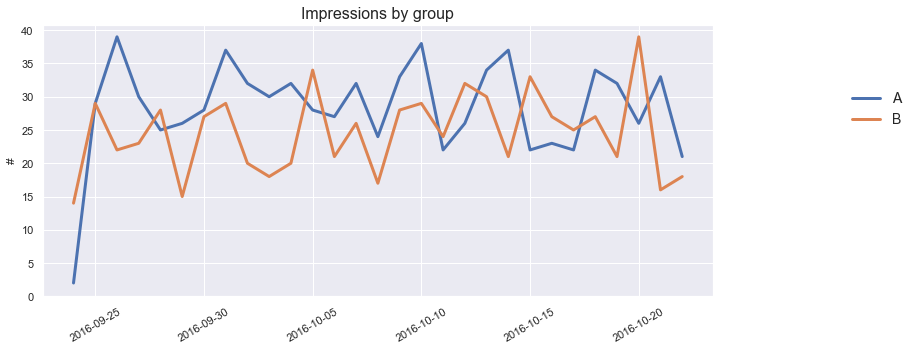

Shapiro group A p-value:  0.0026109404861927032
Shapiro group B p-value:  0.7868756055831909
F test p-value:  0.7999708278057935
Mann-Whitney U test:  0.005945419127803248
Statistical significance:  True


<Figure size 432x288 with 0 Axes>

In [17]:
# Render chart and pvalues using AlphaB
bucket_test = BucketTest(
    df=df,
    variable='impressions',
    group='group',
    x_axis='timestamp',
    custom_title='Impressions by group',
    custom_ylabel='#',
    custom_day_interval=5
)
bucket_test.render()
bucket_test.compute_pvalues()

## Analysis without using AlphaB

### Chart

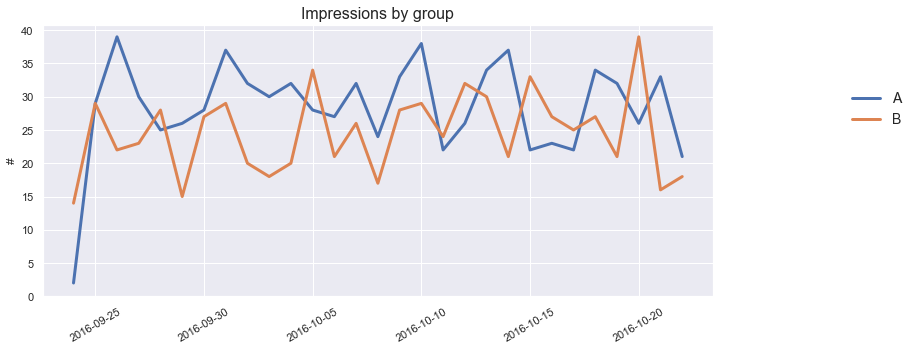

In [18]:
# Render chart without using AlphaB
fig, ax = plt.subplots(figsize=(12, 5))
for group_value in df['group'].unique():
    df_group = df[df['group'] == group_value]
    df_group.set_index('timestamp', drop=False, inplace=True)
    ax.plot(df_group['impressions'], label=group_value, linewidth=3)
plt.title('Impressions by group', fontsize=16)
plt.legend(bbox_to_anchor=(1.3, 0.8), frameon=False, fontsize=14)
plt.ylabel('#')
plt.ylim(0, )
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show();

### Statistical significance

In [19]:
# Assign to variables
group_a = df[df['group'] == 'A']['impressions']
group_b = df[df['group'] == 'B']['impressions']

In [20]:
# Normality test
normality_group_a, normality_pvalue_a = shapiro(group_a)
normality_group_b, normality_pvalue_b = shapiro(group_b)
print('Shapiro group A p-value: ', normality_pvalue_a)
print('Shapiro group B p-value: ', normality_pvalue_b)

Shapiro group A p-value:  0.0026109404861927032
Shapiro group B p-value:  0.7868756055831909


In [21]:
# Variance
F = np.var(group_a) / np.var(group_b)
critical_value_group_a = len(group_a) - 1
critical_value_group_b = len(group_b) - 1
f_pvalue = f.cdf(F, critical_value_group_a, critical_value_group_b)
print('F test p-value: ', f_pvalue)

F test p-value:  0.7999708278057935


In [22]:
# Mann-Whitney test
mannwhitneyu_pvalue = mannwhitneyu(group_a, group_b).pvalue
print('Mann-Whitney U test: ', mannwhitneyu_pvalue)
print("Statistical significance: ", mannwhitneyu_pvalue <= 0.01)

Mann-Whitney U test:  0.005945419127803248
Statistical significance:  True


## AlphaB vs manual approach

The charts and statistical significance analysis generated using AlphaB are the same as the once created with a manual approach.